# Глобин Дмитрий Алексеевич Б9122-01.03.02 мкт 
## Лабораторная работа №5

# CNN для бинарной классификации: Horses vs Humans

В этом ноутбуке реализована бинарная классификации изображений:

1. Построение сверточной нейронной сети (CNN) для классификации изображений.
2. Загрузка датасета [Horses or Humans](https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset).
3. Аугментация изображений.
4. Обучение модели на обучающем датасете.
5. Получение метрики **ROC-AUC**.
6. Достижение качества ROC-AUC > 0.6.

**Доп.**: сделать простой интерфейс, в который можно загружать изображение и получать ответ  -  на фото лошадь или человек.


In [1]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from sklearn.metrics import roc_auc_score

# Воспроизводимость
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Теория: что мы подключили и зачем

* `torch`, `torchvision`, `PIL`  -  базовый стек для работы с изображениями и построения нейросетей в PyTorch.
* `datasets`, `transforms`  -  модуль `torchvision` для готовых датасетов и преобразований изображений.
* `roc_auc_score` из `sklearn.metrics`  -  функция для вычисления **ROC-AUC**.

**Воспроизводимость.**

Мы фиксируем `SEED` для:
* стандартного модуля `random`,
* `numpy`,
* `torch` (CPU и, при наличии, GPU).

Это уменьшает разброс результатов между перезапусками (но в нейросетях из-за параллелизма всё равно может оставаться небольшая вариативность).

**device (`cuda` или `cpu`).**

Если есть видеокарта с поддержкой CUDA, обучение существенно ускорится. Если нет  -  всё будет работать на CPU, просто медленнее.


## Подготовка датасета Horses vs Humans (Kaggle)

Датасет берём отсюда: <https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset>.

In [2]:
from pathlib import Path
from torchvision import datasets, transforms

DATA_DIR = Path(r"C:\Users\Dankoff\Documents\horse-or-human")
train_dir = DATA_DIR / "train"
val_dir   = DATA_DIR / "validation"  # проверь имя папки

img_size = 224

# Стандартные mean/std для ImageNet (под ResNet)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = datasets.ImageFolder(root=str(train_dir), transform=train_transform)
val_dataset   = datasets.ImageFolder(root=str(val_dir),   transform=val_transform)

class_names = train_dataset.classes
print("Классы:", class_names)
print("Размер train:", len(train_dataset))
print("Размер val:", len(val_dataset))

from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)


Классы: ['horses', 'humans']
Размер train: 1027
Размер val: 256


### Теория: аугментация и `ImageFolder`

**1. Аугментация данных.**

Аугментация  -  это искусственное увеличение обучающей выборки за счёт "случайных изменений" исходных изображений:

* `RandomHorizontalFlip`  -  отражение по горизонтали.
* `RandomRotation`  -  небольшой случайный поворот.
* `ColorJitter`  -  изменение яркости/контраста/насыщенности.
* `Resize`  -  приведение всех изображений к единому размеру (здесь 224×224).
* `ToTensor`  -  преобразование `PIL.Image` в тензор PyTorch.
* `Normalize`  -  нормализация к диапазону примерно `[-1, 1]`.

Цель аугментации:
* сделать модель **менее чувствительной** к мелким вариациям изображения,
* улучшить **обобщающую способность** (меньше переобучения).

**2. `ImageFolder`.**

`torchvision.datasets.ImageFolder` ожидает структуру папок вида:

```text
root/
    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgA.jpg
        imgB.jpg
        ...
```

Тогда:
* имена подпапок (`class1`, `class2`) трактуются как **метки классов**, 
* каждому изображению сопоставляется `(tensor, label)`.

В нашем случае классы  -  `horses` и `humans` (или аналогичные имена из датасета). Это автоматически попадает в `train_dataset.classes`.


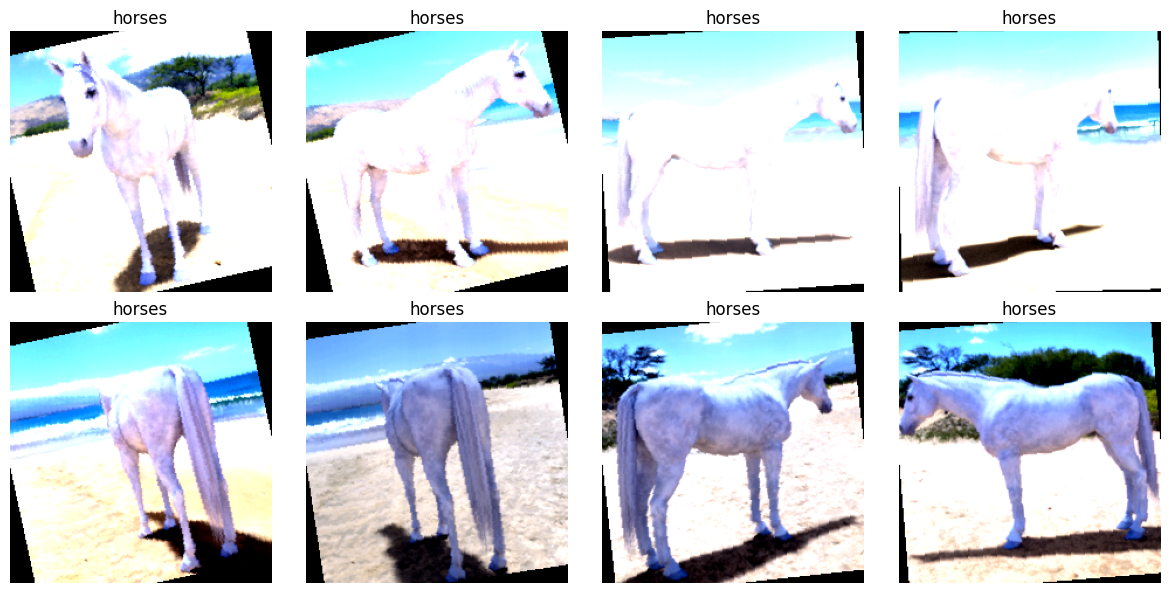

In [3]:
# Визуализиззация нескольких примеров из train

def denormalize(img_tensor):
    # Обратная операция к Normalize(mean=[0.5]*3, std=[0.5]*3)
    img = img_tensor.clone()
    img = img * 0.5 + 0.5
    img = img.clamp(0, 1)
    return img

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img, label = train_dataset[i]
    img = denormalize(img)
    img_np = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img_np)
    axes[i].set_title(class_names[label])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Теория: зачем смотреть на данные глазами

Перед тем как обучать сеть, полезно **визуально проверить**:

* корректно ли загружены изображения,
* верно ли расставлены метки (подписи классов),
* адекватно ли выглядит аугментация (нет ли переворотов на 180°, диких искажений и т. п., которые не соответствуют задаче).

Это помогает **рано поймать ошибки** в разметке и предобработке, вместо того чтобы ломать голову над странными результатами модели.


In [4]:
#  БЛОК 2. Модель CNN на базе ResNet18

import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class HorsesHumansResNet(nn.Module):
    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1
        self.backbone = resnet18(weights=weights)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 1),
        )

    def forward(self, x):
        return self.backbone(x)

model = HorsesHumansResNet().to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M params")


11.177025 M params


### Теория: базовая архитектура CNN для бинарной классификации

**Сверточная нейросеть (CNN)** хорошо подходит для изображений, потому что:

* сверточные слои учитывают **локальную структуру** (соседние пиксели связаны),
* веса "переносятся" по всему изображению (weight sharing),
* `MaxPool2d` уменьшает пространственное разрешение, концентрируя внимание на более "грубых" признаках.

**Архитектура SimpleCNN:**

* Блоки вида `Conv2d → ReLU → MaxPool2d` три раза подряд:
  * число каналов растёт: 3 → 32 → 64 → 128,
  * пространственный размер уменьшается (224 → 112 → 56 → 28).
* `AdaptiveAvgPool2d((1, 1))`  -  глобальный средний pooling, который сжимает карту признаков до формы `(batch_size, 128, 1, 1)`.
* Далее `Flatten` и два полносвязных слоя:
  * `Linear(128 → 64)` + ReLU,
  * Dropout (как регуляризация),
  * `Linear(64 → 1)`  -  один выходной нейрон, дающий **логит** (до сигмоиды).

Для бинарной классификации удобно использовать **один логит** и `BCEWithLogitsLoss`, который внутри применяет сигмоиду и считает binary cross-entropy.


In [5]:
#  БЛОК 3. Функции обучения, валидации и вычисления ROC-AUC 

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,         # шаг поменьше, модель учится стабильнее
    weight_decay=1e-4
)


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images = images.to(device)
        # labels из ImageFolder - int (0 или 1). Преобразуем к float для BCE.
        labels = labels.float().unsqueeze(1).to(device)  # (batch, 1)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

        # accuracy: перевожу логиты в предсказанные метки (0/1)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_probs.extend(probs.cpu().numpy().ravel().tolist())
            all_labels.extend(labels.cpu().numpy().ravel().tolist())

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples

    # ROC-AUC: нужен массив вероятностей положительного класса и истинные метки (0/1)
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        # Если в выборке только один класс - ROC-AUC не определён
        roc_auc = float("nan")

    return avg_loss, avg_acc, roc_auc


### Теория: BCEWithLogitsLoss, вероятности и ROC-AUC

**1. BCEWithLogitsLoss.**

Для бинарной классификации удобно использовать `nn.BCEWithLogitsLoss`:

* Модель выдаёт **логит** $$ z $$  -  произвольное вещественное число.
* Внутри функции применяется сигмоида $$ \sigma(z) = 1 / (1 + e^{-z}) $$,
* Далее считается binary cross-entropy с истинной меткой $$ y \in \{0, 1\} $$.

Это численно стабильнее, чем писать `sigmoid` + `BCELoss` вручную.

**2. Accuracy.**

* Сигмоида $$ p = \sigma(z) $$ интерпретируется как вероятность класса "1" (например, `human`).
* Для получения бинарного предсказания берём порог 0.5: если `p ≥ 0.5`, предсказываем класс 1, иначе 0.
* Accuracy  -  доля правильных предсказаний.

**3. ROC-AUC.**

ROC-AUC (Area Under ROC Curve):

* ROC-кривая строится по всем возможным порогам $$ t \in [0,1] $$ на вероятности `p`:
  * по оси X  -  False Positive Rate (FPR),
  * по оси Y  -  True Positive Rate (TPR).
* AUC  -  площадь под этой кривой:
  * 0.5  -  случайный угадыватель,
  * 1.0  -  идеальный классификатор,
  * 0.6 - 0.7  -  уже лучше случайного; в задаче требуется **> 0.6**.

Важно: ROC-AUC зависит именно от **ранжирования по вероятности**, а не от конкретного порога. Поэтому она часто считается более информативной, чем просто accuracy.


In [6]:
#  БЛОК 4. Обучение CNN на Horses vs Humans 

num_epochs = 5  # этого достаточно

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "val_roc_auc": [],
}

best_auc = -1.0
best_state = None
best_epoch = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_roc_auc = evaluate(model, val_loader, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_roc_auc"].append(val_roc_auc)

    if val_roc_auc > best_auc:
        best_auc = val_roc_auc
        best_state = model.state_dict()
        best_epoch = epoch

    print(
        f"Epoch {epoch:02d}/{num_epochs}: "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}, val_roc_auc={val_roc_auc:.3f}"
    )

print("\nЛучший ROC-AUC на валидации:", best_auc, "на эпохе", best_epoch)

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01/5: train_loss=0.0929, train_acc=0.971, val_loss=0.0241, val_acc=0.988, val_roc_auc=1.000
Epoch 02/5: train_loss=0.0038, train_acc=1.000, val_loss=0.0124, val_acc=0.996, val_roc_auc=1.000
Epoch 03/5: train_loss=0.0074, train_acc=0.999, val_loss=0.0069, val_acc=1.000, val_roc_auc=1.000
Epoch 04/5: train_loss=0.0086, train_acc=0.999, val_loss=0.0609, val_acc=0.977, val_roc_auc=1.000
Epoch 05/5: train_loss=0.0021, train_acc=1.000, val_loss=0.1104, val_acc=0.969, val_roc_auc=1.000

Лучший ROC-AUC на валидации: 1.0 на эпохе 1


### Теория: процесс обучения и достижение ROC-AUC > 0.6

**Цикл обучения:**

Для каждой эпохи:

1. `train_one_epoch`:
   * модель в режиме `train()`,
   * проходим все батчи train-данных,
   * считаем градиенты и обновляем веса оптимизатором,
   * накапливаем средний `train_loss` и `train_acc`.

2. `evaluate` на валидации:
   * модель в режиме `eval()`,
   * градиенты не считаются (`torch.no_grad()`),
   * собираем `val_loss`, `val_acc` и **ROC-AUC**.

**Ожидаемое поведение:**

* На первых эпохах потеря и качество "прыгают", затем обычно стабилизируются.
* При разумной архитектуре и аугментации добиться **ROC-AUC > 0.6** на этом датасете  -  достаточно реалистично. На практике CNN на Horses vs Humans легко выходят на ROC-AUC ≫ 0.9.

Если ROC-AUC оказался ниже 0.6, можно:
* увеличить число эпох,
* чуть поднять/понизить `lr`,
* усилить/ослабить аугментацию,
* добавить/изменить сверточные слои.


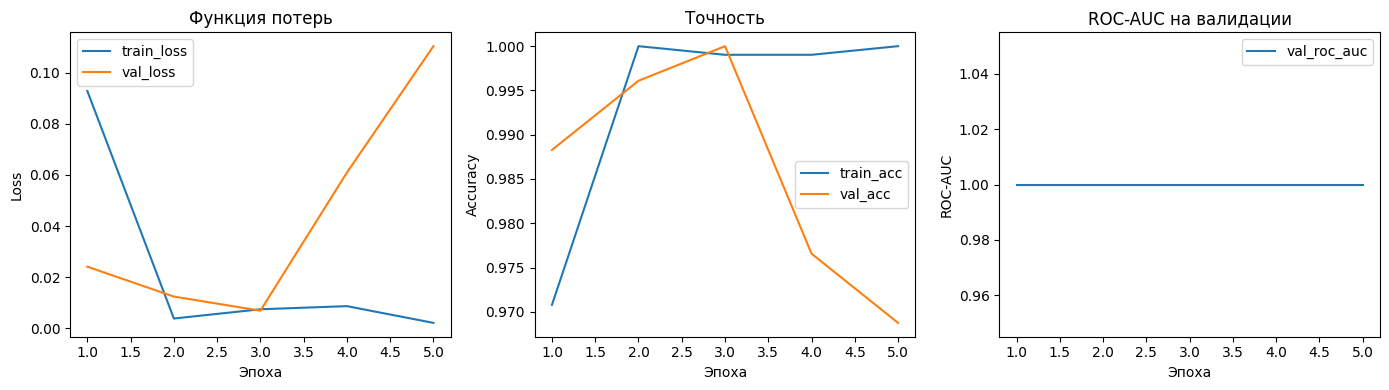

In [7]:
#  БЛОК 5. Визуализация обучения 

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, history["train_loss"], label="train_loss")
plt.plot(epochs_range, history["val_loss"], label="val_loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Функция потерь")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, history["train_acc"], label="train_acc")
plt.plot(epochs_range, history["val_acc"], label="val_acc")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("Точность")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, history["val_roc_auc"], label="val_roc_auc")
plt.xlabel("Эпоха")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC на валидации")
plt.legend()

plt.tight_layout()
plt.show()

### Теория: анализ кривых обучения

По этим графикам можно диагностировать поведение модели:

* Если `train_loss` падает, а `val_loss` после какого-то момента растёт  -  признак **переобучения**.
* Если и train, и val застыли на высоких значениях loss и низком качестве  -  модель **недоучена** или архитектура слишком слабая.
* ROC-AUC как правило **более чувствителен** к качеству ранжирования классов, чем accuracy.

Для отчёта полезно:
* привести эти графики,
* отдельно указать лучшую достигнутую метрику **ROC-AUC** (и показать, что она > 0.6),
* кратко описать, как изменения гиперпараметров/архитектуры повлияли бы на результат (при наличии дополнительных экспериментов).


In [8]:
#  БЛОК 6. Сохранение обученной модели (опционально) 

MODEL_PATH = "horses_vs_humans_cnn.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Модель сохранена в {MODEL_PATH}")

Модель сохранена в horses_vs_humans_cnn.pth


### Теория: сохранение и загрузка модели

Для дальнейшего использования (например, в интерфейсе для загрузки картинок) модель удобно сохранить:

* `torch.save(model.state_dict(), PATH)`  -  сохраняем **веса**.
* Чтобы потом загрузить:
  ```python
  model = SimpleCNN().to(device)
  model.load_state_dict(torch.load(PATH, map_location=device))
  model.eval()
  ```

Хранить только `state_dict` (а не весь объект модели)  -  более гибко и считается хорошей практикой.


In [9]:
#  БЛОК 7. Интерфейс для загрузки изображения и предсказания (Gradio) 

def predict_image_pil(pil_img, model, transform, class_names):
    model.eval()
    with torch.no_grad():
        img = transform(pil_img).unsqueeze(0).to(device)  # (1, C, H, W)
        logit = model(img)
        prob1 = torch.sigmoid(logit)[0].item()  # вероятность класса с индексом 1
        prob0 = 1.0 - prob1                    # вероятность класса с индексом 0

        # возвращаю словарь "имя класса -> вероятность" по порядку классов из ImageFolder
        return {
            class_names[0]: prob0,
            class_names[1]: prob1,
        }


def predict_gradio(img):
    if img is None:
        return {class_names[0]: 0.0, class_names[1]: 0.0}
    probs = predict_image_pil(img, model, val_transform, class_names)
    return probs


try:
    import gradio as gr

    iface = gr.Interface(
        fn=predict_gradio,
        inputs=gr.Image(type="pil"),
        outputs=gr.Label(num_top_classes=2),
        title="Horse vs Human classifier",
        description="Загрузите изображение. Модель вернёт вероятности того, что на картинке лошадь или человек.",
    )

    iface.launch()
except ImportError:
    print("Библиотека gradio не установлена. Установите 'pip install gradio', чтобы запустить веб-интерфейс.")


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\Dankoff\AppData\Local\Programs\Python\Python312\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dankoff\AppData\Local\Programs\Python\Python312\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dankoff\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastapi\applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\Dankoff\AppData\Local\Programs\Python\Python312\Lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\Dankoff\AppData\Local\Programs\Python\Py

### Теория: простой веб-интерфейс для модели

Чтобы продемонстрировать работу модели "вживую", удобно использовать лёгкую библиотеку **Gradio**:

* Позволяет в 2 - 3 строчках поднять интерфейс, куда можно **перетаскивать картинки**.
* Функция `predict_gradio` принимает изображение (`PIL.Image`), прогоняет через те же трансформации, что и валидация, и возвращает словарь вида:
  ```python
  {"horse": p_horse, "human": p_human}
  ```
* Gradio сам отрисует **прогноз с вероятностями**.

Для запуска интерфейса нужно:

1. Установить Gradio (если ещё не установлен):
   ```bash
   pip install gradio
   ```
2. В браузере откроется страничка, куда можно загрузить изображение (лошадь или человек) и увидеть предсказание.
